# King County Sales Assessment

In [67]:
# Import relevant modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, ShuffleSplit
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

In [68]:
# Import data
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [69]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [71]:
# putting price in the logarithmic scale raises all coefficients later on, done here for efficiency
df['l_price'] = np.log(df['price'])

In [72]:
# Grade is ordinal, so here we convert the column values to a 1-10 scale, rather than the 3-13 with trailing string
# Note to self : get better at lambda functions, this one took an hour and a half to figure out.
df['grade_final'] = df.grade.map(lambda x: int(x[0]))

# Baseline

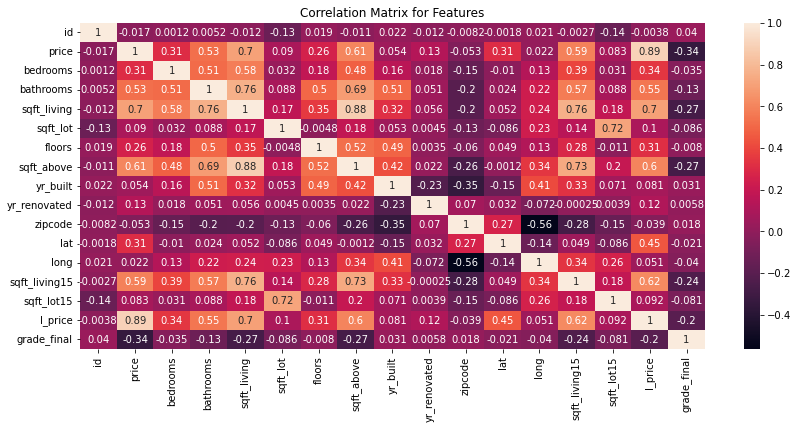

In [73]:
# Lets throw up a heat map to see our simple correlation matrix
plt.figure(figsize=(14, 6))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Matrix for Features')
plt.show()

In [74]:
# Drop NA values to least common denominator to allow for most comparisons across same size columns
df_clean = df.dropna(axis = 0, how = 'any')

In [75]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15762 entries, 1 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15762 non-null  int64  
 1   date           15762 non-null  object 
 2   price          15762 non-null  float64
 3   bedrooms       15762 non-null  int64  
 4   bathrooms      15762 non-null  float64
 5   sqft_living    15762 non-null  int64  
 6   sqft_lot       15762 non-null  int64  
 7   floors         15762 non-null  float64
 8   waterfront     15762 non-null  object 
 9   view           15762 non-null  object 
 10  condition      15762 non-null  object 
 11  grade          15762 non-null  object 
 12  sqft_above     15762 non-null  int64  
 13  sqft_basement  15762 non-null  object 
 14  yr_built       15762 non-null  int64  
 15  yr_renovated   15762 non-null  float64
 16  zipcode        15762 non-null  int64  
 17  lat            15762 non-null  float64
 18  long  

In [76]:
# Create dummies for categorical variables
df_dum = pd.get_dummies(df_clean, columns = ['waterfront', 'zipcode'], drop_first = True)

In [77]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15762 entries, 1 to 21596
Data columns (total 91 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              15762 non-null  int64  
 1   date            15762 non-null  object 
 2   price           15762 non-null  float64
 3   bedrooms        15762 non-null  int64  
 4   bathrooms       15762 non-null  float64
 5   sqft_living     15762 non-null  int64  
 6   sqft_lot        15762 non-null  int64  
 7   floors          15762 non-null  float64
 8   view            15762 non-null  object 
 9   condition       15762 non-null  object 
 10  grade           15762 non-null  object 
 11  sqft_above      15762 non-null  int64  
 12  sqft_basement   15762 non-null  object 
 13  yr_built        15762 non-null  int64  
 14  yr_renovated    15762 non-null  float64
 15  lat             15762 non-null  float64
 16  long            15762 non-null  float64
 17  sqft_living15   15762 non-null 

In [78]:
df_dum.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'l_price', 'grade_final',
       'waterfront_YES', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
       'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008',
       'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019',
       'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038',
       'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045',
       'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98074', 'zipcode_

In [122]:
# Establish baseline model for strong predictor, ZIP code
X, y = df_dum.drop(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'l_price', 'grade_final',
       'waterfront_YES'], axis=1), df_dum['l_price']
X = sm.add_constant(X)
model1 = sm.OLS(y, X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.164e+29
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:54:54   Log-Likelihood:             4.8812e+05
No. Observations:               15762   AIC:                        -9.761e+05
Df Residuals:                   15689   BIC:                        -9.755e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.665e-14   3.17e-15     -8.402      0.000   -3.29e-14   -2.04e-14
grade_final   -2.109e-15   3.81e-17    -55.380      0.000   -2.18e-15   -2.03e-15
zipcode_98002  9.548e-15   8.89e-16     10.735      0.000     7.8e-15    1.13e-14
zipcode_98003 -4.174e-14   7.96e-16    -52.441      0.000   -4.33e-14   -4.02e-14
zipcode_98004  1.332e-15   8.66e-16      1.538      0.124   -3.65e-16    3.03e-15
zipcode_98005  1.643e-14   9.69e-16     16.963      0.000    1.45e-14    1.83e-14
zipcode_98006 -8.882e-15   7.52e-16    -11.804      0.000   -1.04e-14   -7.41e-15
zipcode_98007 -8.216e-15   1.03e-15     -7.956      0.000   -1.02e-14   -6.19e-15
zipcode_98008 -1.421e-14   8.24e-16    -17.252      0.000   -1.58e-14   -1.26e-14
zipcode_98010  -2.22e-16   1.17e-15     -0.190      0.849   -2.51e-15    2.06e-15
zipcode_98011 -6.661e-15   9.21e-16     -7.231      0.000   -8.47e-15   -4.86e-15
zipcode_98014  1.155e-14   1.05e-15     10.989      0.000    9.49e-15    1.36e-14
zipcode_98019 -3.886e-15   9.41e-16     -4.131      0.000   -5.73e-15   -2.04e-15
zipcode_98022 -1.776e-15   8.52e-16     -2.084      0.037   -3.45e-15   -1.06e-16
zipcode_98023 -3.886e-15   7.02e-16     -5.533      0.000   -5.26e-15   -2.51e-15
zipcode_98024 -1.377e-14   1.26e-15    -10.891      0.000   -1.62e-14   -1.13e-14
zipcode_98027 -4.663e-15   7.55e-16     -6.176      0.000   -6.14e-15   -3.18e-15
zipcode_98028  3.608e-15   8.13e-16      4.436      0.000    2.01e-15     5.2e-15
zipcode_98029  4.441e-15   7.94e-16      5.591      0.000    2.88e-15       6e-15
zipcode_98030 -6.772e-15   8.32e-16     -8.144      0.000    -8.4e-15   -5.14e-15
zipcode_98031   2.22e-15   8.11e-16      2.737      0.006     6.3e-16    3.81e-15
zipcode_98032 -1.332e-15   1.02e-15     -1.305      0.192   -3.33e-15    6.68e-16
zipcode_98033   2.22e-15   7.65e-16      2.902      0.004    7.21e-16    3.72e-15
zipcode_98034 -8.882e-16   7.08e-16     -1.255      0.210   -2.28e-15    4.99e-16
zipcode_98038 -1.998e-15   6.83e-16     -2.926      0.003   -3.34e-15    -6.6e-16
zipcode_98039 -8.882e-15   1.61e-15     -5.520      0.000    -1.2e-14   -5.73e-15
zipcode_98040          0   8.78e-16          0      1.000   -1.72e-15    1.72e-15
zipcode_98042  -5.44e-15   6.89e-16     -7.896      0.000   -6.79e-15   -4.09e-15
zipcode_98045  2.248e-15   8.73e-16      2.576      0.010    5.37e-16    3.96e-15
zipcode_98052 -3.109e-15   7.19e-16     -4.326      0.000   -4.52e-15    -1.7e-15
zipcode_98053 -7.327e-15   7.67e-16     -9.553      0.000   -8.83e-15   -5.82e-15
zipcode_98055  7.772e-16   8.16e-16      0.953      0.341   -8.21e-16    2.38e-15
zipcode_98056 -3.442e-15   7.39e-16     -4.659      0.000   -4.89e-15   -1.99e-15
zipcode_98058 -2.665e-15   7.24e-16     -3.682      0.000   -4.08e-15   -1.25e-15
zipcode_98059 -9.825e-15   7.32e-16    -13.421   

# Final Model

In [110]:
# Assign final predictors and dependent variable
X, y = df_dum.drop(['id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'l_price', 'grade_final'
       ], axis=1), df_dum['l_price']

In [113]:
# Prepare train and test data from X and y variables for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [114]:
# Inspect residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test
print(train_residuals)
print(test_residuals)

18060    0.007095
4178    -0.058638
13219    0.052466
2839    -0.209146
5520     0.222499
           ...   
7129     0.029397
18336    0.142288
7384    -0.238669
1159    -0.545981
9955     0.133471
Name: l_price, Length: 12609, dtype: float64
8446     0.280807
7473    -0.192722
20534    0.192190
5063     0.112550
17989   -0.253212
           ...   
2330    -0.073482
10260    0.057059
16786    0.167181
8159     0.042117
10136    0.271953
Name: l_price, Length: 3153, dtype: float64


In [115]:
# Determine MSE
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.045306101739125346
Test Mean Squarred Error: 0.04565020594807442


In [116]:
X = sm.add_constant(X)
model1 = sm.OLS(y, X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1129.
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:41:24   Log-Likelihood:                 2018.1
No. Observations:               15762   AIC:                            -3892.
Df Residuals:                   15690   BIC:                            -3340.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.8345      0.014    850.962      0.000      11.807      11.862
sqft_living        0.0003   2.07e-06    162.085      0.000       0.000       0.000
waterfront_YES     0.6714      0.020     33.240      0.000       0.632       0.711
zipcode_98002     -0.0384      0.022     -1.744      0.081      -0.082       0.005
zipcode_98003      0.0502      0.020      2.545      0.011       0.012       0.089
zipcode_98004      1.1804      0.020     60.483      0.000       1.142       1.219
zipcode_98005      0.8336      0.023     36.063      0.000       0.788       0.879
zipcode_98006      0.7518      0.018     42.753      0.000       0.717       0.786
zipcode_98007      0.7167      0.025     28.559      0.000       0.668       0.766
zipcode_98008      0.7101      0.020     35.871      0.000       0.671       0.749
zipcode_98010      0.3012      0.029     10.460      0.000       0.245       0.358
zipcode_98011      0.4785      0.023     21.254      0.000       0.434       0.523
zipcode_98014      0.3775      0.026     14.599      0.000       0.327       0.428
zipcode_98019      0.3452      0.023     14.927      0.000       0.300       0.391
zipcode_98022      0.1499      0.021      7.106      0.000       0.109       0.191
zipcode_98023      0.0124      0.017      0.713      0.476      -0.022       0.046
zipcode_98024      0.5022      0.031     16.168      0.000       0.441       0.563
zipcode_98027      0.5681      0.018     31.296      0.000       0.533       0.604
zipcode_98028      0.4461      0.020     22.454      0.000       0.407       0.485
zipcode_98029      0.6761      0.019     35.528      0.000       0.639       0.713
zipcode_98030      0.0848      0.021      4.122      0.000       0.044       0.125
zipcode_98031      0.1050      0.020      5.231      0.000       0.066       0.144
zipcode_98032     -0.0194      0.025     -0.769      0.442      -0.069       0.030
zipcode_98033      0.8427      0.018     46.864      0.000       0.807       0.878
zipcode_98034      0.5820      0.017     33.965      0.000       0.548       0.616
zipcode_98038      0.2038      0.017     12.111      0.000       0.171       0.237
zipcode_98039      1.3287      0.038     34.758      0.000       1.254       1.404
zipcode_98040      0.9921      0.020     49.155      0.000       0.953       1.032
zipcode_98042      0.1048      0.017      6.149      0.000       0.071       0.138
zipcode_98045      0.3951      0.021     18.426      0.000       0.353       0.437
zipcode_98052      0.7110      0.017     41.822      0.000       0.678       0.744
zipcode_98053      0.6408      0.018     35.005      0.000       0.605       0.677
zipcode_98055      0.1500      0.020      7.430      0.000       0.110       0.190
zipcode_98056      0.3399      0.018     18.738      0.000       0.304       0.375
zipcode_9805

''

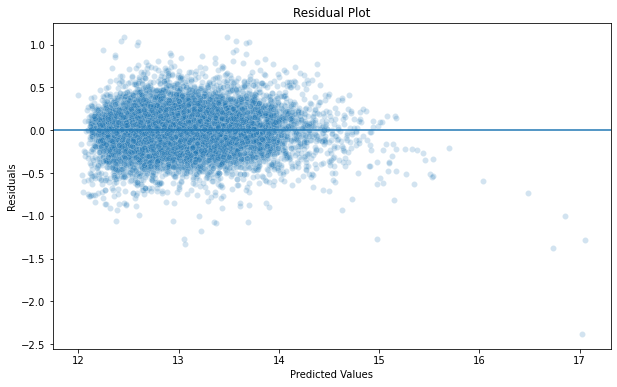

In [121]:
# Create a residual plot to explore possible patterns
df_dum["predicted"] = model1.predict(X)
df_dum["residuals"] = model1.resid

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_dum, x="predicted", y="residuals", alpha = 0.2)
plt.axhline(y=0)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
;

In [61]:
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=linreg,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.8383861232180614
Validation score: 0.8360119069638822
